In [1]:
import pandas as pd
import numpy as np
import sklearn
import gensim

#Vectorizers
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer

#Dimensionality Reduction
from sklearn.decomposition import TruncatedSVD #LSA
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import LatentDirichletAllocation as LDA
from gensim import corpora, models, similarities, matutils #LDA

#Clustering
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
# !conda install -c districtdatalabs yellowbrick
from yellowbrick.cluster import KElbowVisualizer

#Word Embeddings
from gensim.models import Word2Vec

#Pipeline
from sklearn.pipeline import Pipeline

#Bayes Optimization Parameter Tuner
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score

#Visualization
import matplotlib.pyplot as plt

# adjectives = []
# for sent in hp.sents:
#     for word in sent:
#         if 'Harry' in word.string:
#             for child in word.children:
#                 if child.pos_ == 'ADJ': adjectives.append(child.string.strip()) #part of speech         
# Counter(adjectives).most_common(10)


# Import Data

In [2]:
full_df = pd.read_pickle('full_df_preprocessed.pkl')

In [3]:
positive_df = full_df[full_df['sentiment']=='positive']
negative_df = full_df[full_df['sentiment']=='negative']
neutral_df = full_df[full_df['sentiment']=='neutral']

# Pipeline of Vectorization, Dimensionality Reduction, and Clustering Methods

In [4]:
full_df['movie'].value_counts()

lionking          20791
aladdin           19293
beautyandbeast     4571
junglebook         3982
cinderella         2875
Name: movie, dtype: int64

In [5]:
corpus = [items[1] for items in full_df['review_processed'].iteritems()]
Pipeline_TFIDF_LSA = Pipeline([
                ('tfidf', TfidfVectorizer(ngram_range=(1,5), min_df=0.05, stop_words=['movie','film'])),
                ('LSA', TruncatedSVD(n_components=5,random_state=10, n_iter=10))])
TFIDF_LSA = Pipeline_TFIDF_LSA.fit_transform(corpus)
TFIDF_LSA.shape

(51512, 5)

In [6]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    """Function to display topics from Vectorizer after performing Vectorization and Dimensionality Reduction"""
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [7]:
tfidfvec = TfidfVectorizer(ngram_range=(1,5), min_df=0.05, stop_words=['movie', 'film'])
doc_word_tfidfvec = tfidfvec.fit_transform(corpus)
print(doc_word_tfidfvec.shape)
tfidfvec.get_feature_names()
LSA = TruncatedSVD(n_components=5,random_state=10, n_iter=10)
tfidfvec_LSA = LSA.fit_transform(doc_word_tfidfvec) 
display_topics(LSA, tfidfvec.get_feature_names(), 10)

#Normalize before for clustering to get an approximate cosine similarity distance (instead of kmeans default of euclidean distance, which is sensitive to document/review length)
normalized_doc_topic_lsa_tfidf = sklearn.preprocessing.normalize(TFIDF_LSA)

(51512, 58)

Topic  0
not, original, good, great, love, with, like, well, disney, make

Topic  1
love, great, smith, loved, genie, job, amaze, music, kid, beautiful

Topic  2
great, smith, job, loved, genie, music, cast, fun, act, classic

Topic  3
good, smith, genie, love, job, enjoy, music, think, fun, aladdin

Topic  4
original, loved, well, good, remake, story, new, amaze, music, classic


In [8]:
def display_cluster(X,km=[],num_clusters=0):
    """Function to display k-means clusters into 2-dimensional space"""
    color = 'brgcmyk'
    alpha = 0.5
    s = 20
    if num_clusters == 0:
        plt.scatter(X[:,0],X[:,1],c = color[0],alpha = alpha,s = s)
    else:
        for i in range(num_clusters):
            plt.scatter(X[km.labels_==i,0],X[km.labels_==i,1],c = color[i],alpha = alpha,s=s)
            plt.scatter(km.cluster_centers_[i][0],km.cluster_centers_[i][1],c = color[i], marker = 'x', s = 100)

Elbow Method Plot (inertia vs. number of clusters)

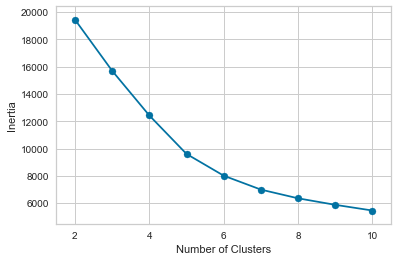

In [9]:
list_num_clusters = list(range(2,11))

inertia = []

for num_clusters in list_num_clusters:
    km = KMeans(n_clusters=num_clusters, random_state=10, init='k-means++')
    km.fit_predict(normalized_doc_topic_lsa_tfidf)
    inertia.append(km.inertia_)
    
plt.plot(list_num_clusters,inertia)
plt.scatter(list_num_clusters,inertia)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia');


#center: 4 docs closest --> cosine similarity

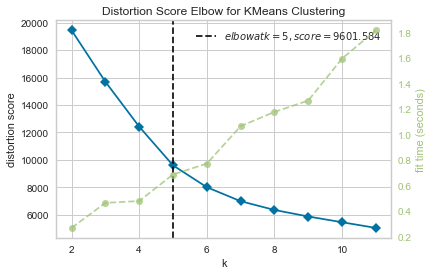

In [10]:
# Instantiate the clustering model and visualizer
visualizer = KElbowVisualizer(km, k=(2,12))

visualizer.fit(normalized_doc_topic_lsa_tfidf)        # Fit the data to the visualizer
visualizer.show()  # Finalize and render the figure
elbow_full = visualizer.elbow_value_

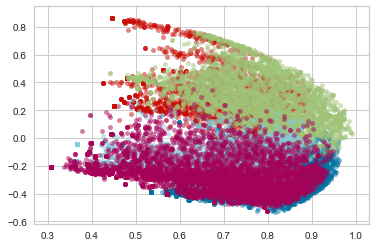

In [11]:
display_cluster(normalized_doc_topic_lsa_tfidf, km, elbow_full)

In [12]:

km = KMeans(n_clusters=elbow_full, random_state=10, init='k-means++')
km.fit_predict(normalized_doc_topic_lsa_tfidf)
full_df['cluster'] = km.labels_

In [13]:
full_df

,review_text,movie,review_site,rating,sentiment,review_tokens,review_processed,cluster
0,"Disney, WHAT. HAVE. YOU. DONE Just to be clea...",lionking,imdb,1,negative,"[disney, clear, time, favorite, movie, not, st...",disney clear time favorite movie not stress en...,1
1,No soul. The original Lion King is one of my ...,lionking,imdb,1,negative,"[no, soul, original, lion, king, favorite, mov...",no soul original lion king favorite movie time...,1
5,Seriously? So anyone else notice it has a hig...,lionking,imdb,1,negative,"[seriously, notice, high, score, 7.5, rating, ...",seriously notice high score 7.5 rating not str...,1
6,Overrated and way too much spotlight on beyon...,lionking,imdb,1,negative,"[overrated, way, spotlight, beyonce, lion, kin...",overrated way spotlight beyonce lion king only...,1
8,Terrible acting!! Doesn't compare to the orig...,lionking,imdb,1,negative,"[terrible, act, not, compare, original, love, ...",terrible act not compare original love origina...,1
...,...,...,...,...,...,...,...,...
3040,A magically wonderful film filled with adventu...,cinderella,rottentomatoes,5,positive,"[magically, wonderful, film, fill, with, adven...",magically wonderful film fill with adventure f...,1
3041,Disney has overdid the faithfulness of their o...,cinderella,rottentomatoes,4,positive,"[disney, overdo, faithfulness, animate, classi...",disney overdo faithfulness animate classic pro...,3
3042,Magic....that's about right. A re-tell of the ...,cinderella,rottentomatoes,4,positive,"[magic, ...., right, tell, original, disney, m...",magic .... right tell original disney movie wi...,3
3043,A good movie that sets it apart from the origi...,cinderella,rottentomatoes,4,positive,"[good, movie, set, apart, original, story, cin...",good movie set apart original story cinderella...,0


In [14]:
full_df['cluster'].value_counts()

1    18356
3     8919
2     8733
0     8522
4     6982
Name: cluster, dtype: int64

In [15]:
corpus = [items[1] for items in full_df['review_processed'].iteritems()]

tfidfvec = TfidfVectorizer(ngram_range=(1,5), min_df=0.05, stop_words=['movie', 'film'])
doc_word_tfidfvec = tfidfvec.fit_transform(corpus)
print(doc_word_tfidfvec.shape)
tfidfvec.get_feature_names()
LSA = TruncatedSVD(n_components=3,random_state=10, n_iter=10)
tfidfvec_LSA = LSA.fit_transform(doc_word_tfidfvec) 
print(tfidfvec_LSA.shape)
display_topics(LSA, tfidfvec.get_feature_names(), 10)

(51512, 58)
(51512, 3)

Topic  0
not, original, good, great, love, with, like, well, disney, make

Topic  1
love, great, smith, loved, genie, job, amaze, music, kid, beautiful

Topic  2
great, smith, job, loved, genie, music, cast, fun, act, enjoy


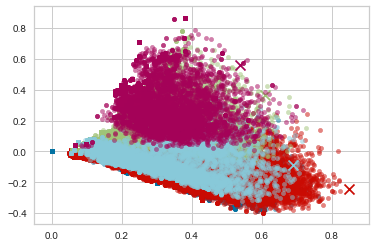

In [16]:
display_cluster(tfidfvec_LSA, km, 5)

# Positive Reviews

In [18]:
positive_df = full_df[full_df['sentiment']=='positive']


positive_corpus = [items[1] for items in positive_df['review_processed'].iteritems()]
Pipeline_TFIDF_LSA = Pipeline([
                ('tfidf', TfidfVectorizer(ngram_range=(1,5), min_df=0.05, stop_words=['movie','film'])),
                ('LSA', TruncatedSVD(n_components=5,random_state=10, n_iter=10))])
TFIDF_LSA_positive = Pipeline_TFIDF_LSA.fit_transform(positive_corpus)

In [19]:
normalized_doc_topic_lsa_tfidf_pos = sklearn.preprocessing.normalize(TFIDF_LSA_positive)

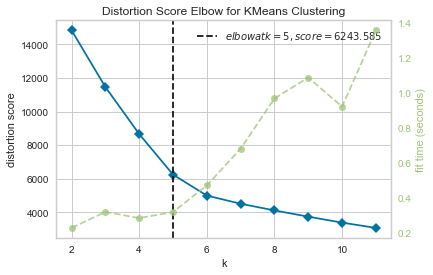

In [20]:
visualizer = KElbowVisualizer(km, k=(2,12))

visualizer.fit(normalized_doc_topic_lsa_tfidf_pos)        # Fit the data to the visualizer
visualizer.show()  # Finalize and render the figure
elbow_pos = visualizer.elbow_value_

In [21]:
km = KMeans(n_clusters=elbow_pos, random_state=10, init='k-means++')
km.fit_predict(normalized_doc_topic_lsa_tfidf_pos)
positive_df['cluster'] = km.labels_
positive_df

/Users/kristentokunaga/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,review_text,movie,review_site,rating,sentiment,review_tokens,review_processed,cluster
260,Wonderful Animal Movie 2019 Rating 9.1/10This...,lionking,imdb,9,positive,"[wonderful, animal, movie, 2019, rating, 9.1/1...",wonderful animal movie 2019 rating 9.1/10this ...,2
381,Don't listen to the Critics!!! This movie is ...,lionking,imdb,10,positive,"[not, listen, critics, movie, amazing, imagery...",not listen critics movie amazing imagery color...,0
469,Great movie The lion king is propably the bes...,lionking,imdb,7,positive,"[great, movie, lion, king, propably, well, liv...",great movie lion king propably well live actio...,2
470,Best remake for sure! Don't listen to any cri...,lionking,imdb,10,positive,"[best, remake, sure, not, listen, critic, peop...",best remake sure not listen critic people like...,0
486,Timon and Pumba save the world If I'm being h...,lionking,imdb,7,positive,"[timon, pumba, save, world, honest, well, timo...",timon pumba save world honest well timon pumba...,3
...,...,...,...,...,...,...,...,...
3040,A magically wonderful film filled with adventu...,cinderella,rottentomatoes,5,positive,"[magically, wonderful, film, fill, with, adven...",magically wonderful film fill with adventure f...,0
3041,Disney has overdid the faithfulness of their o...,cinderella,rottentomatoes,4,positive,"[disney, overdo, faithfulness, animate, classi...",disney overdo faithfulness animate classic pro...,0
3042,Magic....that's about right. A re-tell of the ...,cinderella,rottentomatoes,4,positive,"[magic, ...., right, tell, original, disney, m...",magic .... right tell original disney movie wi...,0
3043,A good movie that sets it apart from the origi...,cinderella,rottentomatoes,4,positive,"[good, movie, set, apart, original, story, cin...",good movie set apart original story cinderella...,3


In [22]:
positive_df['cluster'].value_counts()

0    14547
4     7170
1     5767
2     5652
3     5520
Name: cluster, dtype: int64

In [23]:
tfidfvec = TfidfVectorizer(ngram_range=(1,5), min_df=0.05, stop_words=['movie','film'])
doc_word_tfidfvec_positive = tfidfvec.fit_transform(positive_corpus)
print(doc_word_tfidfvec_positive.shape)
tfidfvec.get_feature_names()
LSA = TruncatedSVD(n_components=3,random_state=10, n_iter=10)
tfidfvec_LSA_positive = LSA.fit_transform(doc_word_tfidfvec_positive) 
print(tfidfvec_LSA_positive.shape)
display_topics(LSA, tfidfvec.get_feature_names(), 10)


(38656, 47)
(38656, 3)

Topic  0
great, not, love, good, original, with, like, smith, disney, story

Topic  1
love, absolutely, kid, amaze, family, awesome, beautiful, music, smith, real

Topic  2
great, smith, job, loved, genie, music, family, awesome, cast, fun


# Negative Reviews

In [24]:
negative_df = full_df[full_df['sentiment']=='negative']

negative_corpus = [items[1] for items in negative_df['review_processed'].iteritems()]
Pipeline_TFIDF_LSA = Pipeline([
                ('tfidf', TfidfVectorizer(ngram_range=(1,5), min_df=0.05, stop_words=['movie','film'])),
                ('LSA', TruncatedSVD(n_components=3,random_state=10, n_iter=10))])
TFIDF_LSA_negative = Pipeline_TFIDF_LSA.fit_transform(negative_corpus)



In [25]:
normalized_doc_topic_lsa_tfidf_neg = sklearn.preprocessing.normalize(TFIDF_LSA_negative)

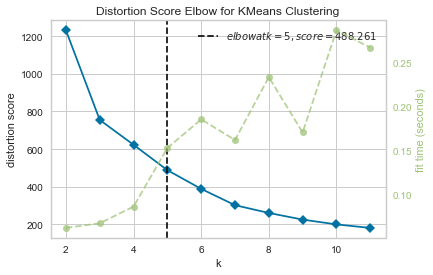

In [26]:
visualizer = KElbowVisualizer(km, k=(2,12))

visualizer.fit(normalized_doc_topic_lsa_tfidf_neg)        # Fit the data to the visualizer
visualizer.show()  # Finalize and render the figure
elbow_neg = visualizer.elbow_value_

In [27]:
km = KMeans(n_clusters=elbow_neg, random_state=10, init='k-means++')
km.fit_predict(sklearn.preprocessing.normalize(TFIDF_LSA_negative))
negative_df['cluster'] = km.labels_
negative_df


/Users/kristentokunaga/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,review_text,movie,review_site,rating,sentiment,review_tokens,review_processed,cluster
0,"Disney, WHAT. HAVE. YOU. DONE Just to be clea...",lionking,imdb,1,negative,"[disney, clear, time, favorite, movie, not, st...",disney clear time favorite movie not stress en...,1
1,No soul. The original Lion King is one of my ...,lionking,imdb,1,negative,"[no, soul, original, lion, king, favorite, mov...",no soul original lion king favorite movie time...,3
5,Seriously? So anyone else notice it has a hig...,lionking,imdb,1,negative,"[seriously, notice, high, score, 7.5, rating, ...",seriously notice high score 7.5 rating not str...,0
6,Overrated and way too much spotlight on beyon...,lionking,imdb,1,negative,"[overrated, way, spotlight, beyonce, lion, kin...",overrated way spotlight beyonce lion king only...,1
8,Terrible acting!! Doesn't compare to the orig...,lionking,imdb,1,negative,"[terrible, act, not, compare, original, love, ...",terrible act not compare original love origina...,1
...,...,...,...,...,...,...,...,...
2954,nothing new to add. still think ever after was...,cinderella,rottentomatoes,2,negative,"[nothing, new, add, think, well, adaptation, c...",nothing new add think well adaptation cinderella,2
2972,Waste of time.not for kids. Only for old foks,cinderella,rottentomatoes,1,negative,"[waste, time.not, kid, only, old, foks]",waste time.not kid only old foks,0
2987,I feel like the real-life incarnation really b...,cinderella,rottentomatoes,2,negative,"[feel, like, real, life, incarnation, bring, h...",feel like real life incarnation bring home rid...,1
3023,The only performance should be mentioned and m...,cinderella,rottentomatoes,2,negative,"[only, performance, mention, mark, cate, perfo...",only performance mention mark cate performance...,3


In [28]:
negative_df['cluster'].value_counts()

3    1799
1    1675
2    1237
0    1055
4     175
Name: cluster, dtype: int64

In [29]:
tfidfvec = TfidfVectorizer(ngram_range=(1,5), min_df=0.05, stop_words=['movie','film'])
doc_word_tfidfvec_negative = tfidfvec.fit_transform(negative_corpus)
print(doc_word_tfidfvec_negative.shape)
tfidfvec.get_feature_names()
LSA = TruncatedSVD(n_components=5,random_state=10, n_iter=10)
tfidfvec_LSA_negative = LSA.fit_transform(doc_word_tfidfvec_negative) 
print(tfidfvec_LSA_negative.shape)
display_topics(LSA, tfidfvec.get_feature_names(), 10)

(5941, 86)
(5941, 5)

Topic  0
not, original, like, with, good, make, feel, well, disney, remake

Topic  1
not, not good, good, smith, genie, bad, singe, think, kid, like

Topic  2
original, well, not, not good, good, cartoon, version, change, watch, music

Topic  3
well, like, version, smith, animate, cartoon, genie, aladdin, way, beast

Topic  4
remake, disney, live, well, action, king, live action, lion, lion king, version


# Neutral Reviews

In [30]:
neutral_df = full_df[full_df['sentiment']=='neutral']

neutral_corpus = [items[1] for items in neutral_df['review_processed'].iteritems()]
Pipeline_TFIDF_LSA = Pipeline([
                ('tfidf', TfidfVectorizer(ngram_range=(1,5), min_df=0.05, stop_words=['movie','film'])),
                ('LSA', TruncatedSVD(n_components=5,random_state=10, n_iter=10))])
TFIDF_LSA_neutral = Pipeline_TFIDF_LSA.fit_transform(neutral_corpus)



In [31]:
normalized_doc_topic_lsa_tfidf_neut = sklearn.preprocessing.normalize(TFIDF_LSA_neutral)

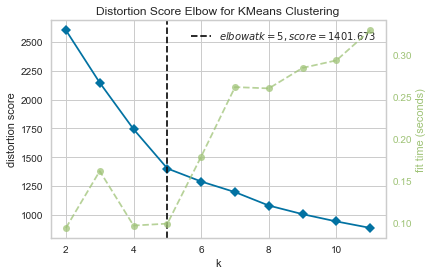

In [32]:
visualizer = KElbowVisualizer(km, k=(2,12))

visualizer.fit(normalized_doc_topic_lsa_tfidf_neut)        # Fit the data to the visualizer
visualizer.show()  # Finalize and render the figure
elbow_neut = visualizer.elbow_value_

In [33]:
km = KMeans(n_clusters=elbow_neut, random_state=10, init='k-means++')
km.fit_predict(normalized_doc_topic_lsa_tfidf_neut)
neutral_df['cluster'] = km.labels_
neutral_df

/Users/kristentokunaga/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,review_text,movie,review_site,rating,sentiment,review_tokens,review_processed,cluster
245,Not bad but not great. I thought the CGI was ...,lionking,imdb,5,neutral,"[not, bad, not, great, think, cgi, great, time...",not bad not great think cgi great time emotion...,2
282,Copyright Why they didn't yet give credit to ...,lionking,imdb,6,neutral,"[copyright, not, give, credit, kimba, white, l...",copyright not give credit kimba white lion???t...,1
422,The same story + CG + blandness = pointless Y...,lionking,imdb,5,neutral,"[story, cg, blandness, pointless, yes, cg, fil...",story cg blandness pointless yes cg film pheno...,2
423,Disappointed It was disappointed to watch it ...,lionking,imdb,5,neutral,"[disappointed, disappoint, watch, with, nothin...",disappointed disappoint watch with nothing new...,3
427,"no point Visually it's amazing, for the first...",lionking,imdb,5,neutral,"[no, point, visually, amaze, ﻿1, 10, minute, s...",no point visually amaze ﻿1 10 minute story son...,2
...,...,...,...,...,...,...,...,...
3018,With unlimited card - Sai and Akeela,cinderella,rottentomatoes,3,neutral,"[with, unlimited, card, sai, akeela]",with unlimited card sai akeela,3
3019,An alright movie. Though if you're looking for...,cinderella,rottentomatoes,3,neutral,"[alright, movie, look, fresh, not]",alright movie look fresh not,2
3022,good but not as good as malificent.,cinderella,rottentomatoes,3,neutral,"[good, not, good, malificent]",good not good malificent,1
3027,"A delightful, beautiful take on the classic fa...",cinderella,rottentomatoes,3,neutral,"[delightful, beautiful, classic, fairytale, ge...",delightful beautiful classic fairytale genuine...,2


In [34]:
neutral_df['cluster'].value_counts()

3    1682
2    1463
0    1385
1    1298
4    1087
Name: cluster, dtype: int64

In [35]:
tfidfvec = TfidfVectorizer(ngram_range=(1,5), min_df=0.05, stop_words=['movie','film'])
doc_word_tfidfvec_neutral = tfidfvec.fit_transform(neutral_corpus)
print(doc_word_tfidfvec_neutral.shape)
tfidfvec.get_feature_names()
LSA = TruncatedSVD(n_components=3,random_state=10, n_iter=10)
tfidfvec_LSA_neutral = LSA.fit_transform(doc_word_tfidfvec_neutral) 
print(tfidfvec_LSA_neutral.shape)
display_topics(LSA, tfidfvec.get_feature_names(), 15)

(6915, 90)
(6915, 3)

Topic  0
not, good, original, like, with, well, great, make, feel, disney, story, song, character, remake, version

Topic  1
good, not, smith, pretty, bad, genie, think, overall, job, great, music, singe, kid, fun, expect

Topic  2
original, well, not, okay, like, lion, lion king, change, king, amaze, emotion, lack, scene, disappoint, bad


In [36]:
#cluster then cosine similarity [find cluster that it's closest to, for that one document]

In [37]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(reviews_df["review"])

ModuleNotFoundError: No module named 'wordcloud'

# Sentiment (Rating) Prediction

In [ ]:
X_train, X_test, y_train, y_test = 

In [ ]:
max_depth_range = list(range(1, 10))
n_estimators_range = list(range(50, 300))
gamma_range = list(range(0, 5))
param_dist = dict(max_depth = max_depth_range, n_estimators = n_estimators_range, gamma = gamma_range)
print(param_dist)

rand = RandomizedSearchCV(XGBClassifier(random_state=41), param_dist, cv=5, scoring='roc_auc')
rand.fit(X_ros_resampled_TRAIN, y_ros_resampled_TRAIN.values.ravel())
rand.cv_results_

print(rand.best_score_)
print(rand.best_params_)

In [ ]:
#RANDOM Oversampling
#print(X_train.columns)
ros = RandomOverSampler(random_state=0)
X_ros_resampled_subtrain, y_ros_resampled_subtrain = ros.fit_sample(X_subtrain,y_subtrain)
X_ros_resampled_subtrain = pd.DataFrame(X_ros_resampled_subtrain, columns = ['Administrative',  'Administrative_Duration',
 'Informational',  'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',  
 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Weekend',
 'Month_Dec', 'Month_Feb', 'Month_Jul', 'Month_Jun', 'Month_Mar', 'Month_May', 'Month_Nov', 'Month_Oct', 'Month_Sep',
 'VisitorType_New_Visitor',  'VisitorType_Returning_Visitor', 'OperatingSystem_1', 'OperatingSystem_2',
 'OperatingSystem_3', 'OperatingSystem_4', 'OperatingSystem_6', 'OperatingSystem_7', 'OperatingSystem_8',
 'Browser_1', 'Browser_2', 'Browser_3', 'Browser_4', 'Browser_5', 'Browser_6', 'Browser_7', 'Browser_8', 'Browser_10',
 'Browser_11', 'Browser_12', 'Browser_13', 'Region_1', 'Region_2', 'Region_3', 'Region_4', 'Region_6', 'Region_7', 'Region_8', 'Region_9', 
 'TrafficType_1', 'TrafficType_2', 'TrafficType_3', 'TrafficType_4', 'TrafficType_5', 'TrafficType_6', 'TrafficType_7',
 'TrafficType_8', 'TrafficType_9', 'TrafficType_10', 'TrafficType_11', 'TrafficType_12', 'TrafficType_13', 'TrafficType_14',
 'TrafficType_15', 'TrafficType_16', 'TrafficType_18', 'TrafficType_19', 'TrafficType_20'])
y_ros_resampled_subtrain = pd.DataFrame(y_ros_resampled_subtrain, columns = ['Purchase'])
y_ros_resampled_subtrain

#SMOTE Oversampling
X_smoted_subtrain, y_smoted_subtrain = SMOTE(random_state=0).fit_sample(X_subtrain,y_subtrain)
X_smoted_subtrain = pd.DataFrame(X_smoted_subtrain, columns = ['Administrative',  'Administrative_Duration',
 'Informational',  'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',  
 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Weekend',
 'Month_Dec', 'Month_Feb', 'Month_Jul', 'Month_Jun', 'Month_Mar', 'Month_May', 'Month_Nov', 'Month_Oct', 'Month_Sep',
 'VisitorType_New_Visitor',  'VisitorType_Returning_Visitor', 'OperatingSystem_1', 'OperatingSystem_2',
 'OperatingSystem_3', 'OperatingSystem_4', 'OperatingSystem_6', 'OperatingSystem_7', 'OperatingSystem_8',
 'Browser_1', 'Browser_2', 'Browser_3', 'Browser_4', 'Browser_5', 'Browser_6', 'Browser_7', 'Browser_8', 'Browser_10',
 'Browser_11', 'Browser_12', 'Browser_13', 'Region_1', 'Region_2', 'Region_3', 'Region_4', 'Region_6', 'Region_7', 'Region_8', 'Region_9', 
 'TrafficType_1', 'TrafficType_2', 'TrafficType_3', 'TrafficType_4', 'TrafficType_5', 'TrafficType_6', 'TrafficType_7',
 'TrafficType_8', 'TrafficType_9', 'TrafficType_10', 'TrafficType_11', 'TrafficType_12', 'TrafficType_13', 'TrafficType_14',
 'TrafficType_15', 'TrafficType_16', 'TrafficType_18', 'TrafficType_19', 'TrafficType_20'])
y_smoted_subtrain = pd.DataFrame(y_smoted_subtrain, columns = ['Purchase'])
y_smoted_subtrain

#ADASYN Oversampling
X_adasyn_subtrain, y_adasyn_subtrain = ADASYN(random_state=0).fit_sample(X_subtrain,y_subtrain)
X_adasyn_subtrain = pd.DataFrame(X_adasyn_subtrain, columns = ['Administrative',  'Administrative_Duration',
 'Informational',  'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',  
 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Weekend',
 'Month_Dec', 'Month_Feb', 'Month_Jul', 'Month_Jun', 'Month_Mar', 'Month_May', 'Month_Nov', 'Month_Oct', 'Month_Sep',
 'VisitorType_New_Visitor',  'VisitorType_Returning_Visitor', 'OperatingSystem_1', 'OperatingSystem_2',
 'OperatingSystem_3', 'OperatingSystem_4', 'OperatingSystem_6', 'OperatingSystem_7', 'OperatingSystem_8',
 'Browser_1', 'Browser_2', 'Browser_3', 'Browser_4', 'Browser_5', 'Browser_6', 'Browser_7', 'Browser_8', 'Browser_10',
 'Browser_11', 'Browser_12', 'Browser_13', 'Region_1', 'Region_2', 'Region_3', 'Region_4', 'Region_6', 'Region_7', 'Region_8', 'Region_9', 
 'TrafficType_1', 'TrafficType_2', 'TrafficType_3', 'TrafficType_4', 'TrafficType_5', 'TrafficType_6', 'TrafficType_7',
 'TrafficType_8', 'TrafficType_9', 'TrafficType_10', 'TrafficType_11', 'TrafficType_12', 'TrafficType_13', 'TrafficType_14',
 'TrafficType_15', 'TrafficType_16', 'TrafficType_18', 'TrafficType_19', 'TrafficType_20'])
y_adasyn_subtrain = pd.DataFrame(y_adasyn_subtrain, columns = ['Purchase'])
y_adasyn_subtrain

In [ ]:
#All models - Imbalanced
Model_Results = pd.DataFrame(columns = ['Model','Fbeta1.5','Fbeta2', 'F1','Precision','Recall', 'P-R_AUC', 'ROC_AUC_train','ROC_AUC_valid','FN','FP','TN','TP','Fit','Predict','Feature_Importance'])
Model_Results['Model'] = ['Dummy_Clas','KNN_Clas_3n','KNN_Clas_5n','KNN_Clas_7n', 'KNN_Clas_3n_weightdist', 'KNN_Clas_3n_Manhattandist','GaussianNB','LogisticRegression','LogisticRegressionCV','SVC',\
                          'DecisionTree_Clas','BalRF_Clas_50est_depth2','BalRF_Clas_100est_depth2','BalRF_Clas_50est_depth3','RF_Clas_50est_depth2','RF_Clas_100est_depth2','RF_Clas_200est_depth2','RF_Clas_100est_depth3','RF_Clas_100est_depth4',\
                          'XGB_Clas_95est_depth2','XGB_Clas_Scale_95est_depth2_PosWt', 'XGB_Clas_100est_depth2','XGB_Clas_50est_depth2','XGB_Clas_95est_depth3','XGB_Clas_95est_depth4','XGB_Clas_95est_depth3_PosWt','XGB_Clas_Scale_100est_depth2_PosWt']
models = DummyClassifier(random_state=41), KNeighborsClassifier(n_neighbors=3), KNeighborsClassifier(n_neighbors=5), KNeighborsClassifier(n_neighbors=7), KNeighborsClassifier(n_neighbors=3, weights='distance'),KNeighborsClassifier(n_neighbors=3, p=1), \
        GaussianNB(), LogisticRegression(C=1.0,random_state=41, max_iter=10000), LogisticRegressionCV(Cs=[100000,10000,1000,100,10,1,0.1,0.01,0.001],random_state=41,cv=5,max_iter=10000), SVC(random_state=41,probability=True), DecisionTreeClassifier(random_state=41), \
        BalancedRandomForestClassifier(n_estimators=50, max_depth=2,random_state=41), BalancedRandomForestClassifier(n_estimators=100, max_depth=2,random_state=41), BalancedRandomForestClassifier(n_estimators=50, max_depth=3,random_state=41), RandomForestClassifier(n_estimators=50, max_depth=2,random_state=41), RandomForestClassifier(n_estimators=100, max_depth=2,random_state=41), RandomForestClassifier(n_estimators=200, max_depth=2,random_state=41), RandomForestClassifier(n_estimators=100, max_depth=3,random_state=41),RandomForestClassifier(n_estimators=100, max_depth=4,random_state=41), \
        XGBClassifier(max_depth=2,n_estimators=95,random_state=41), XGBClassifier(max_depth=2,n_estimators=95,random_state=41,scale_pos_weight=(y_subtrain.values==0).sum()/(y_subtrain.values==1).sum()), XGBClassifier(max_depth=2,n_estimators=100,random_state=41), XGBClassifier(max_depth=2,n_estimators=50,random_state=41), XGBClassifier(max_depth=3,n_estimators=95,random_state=41),XGBClassifier(max_depth=4,n_estimators=95,random_state=41), XGBClassifier(max_depth=3,n_estimators=95,random_state=41,scale_pos_weight=(y_subtrain.values==0).sum()/(y_subtrain.values==1).sum()), XGBClassifier(max_depth=2,n_estimators=100,random_state=41,scale_pos_weight=(y_subtrain.values==0).sum()/(y_subtrain.values==1).sum())

fbeta1_5_list = []
fbeta2_list = []
f1_list = []
precision_list = []
recall_list = []
PR_AUC_list = []
ROC_AUC_train_list = []
ROC_AUC_valid_list = []
FN_list = []
FP_list = []
TN_list = []
TP_list = []
Fit_list = []
Predict_list = []
Feature_Importance_list = []


#std scale train and test: recommended workflow 
#scaler.fit x-->model.fit --> scaler transform x
#model.fit, scaler transform xtest 
#model learning from data training 
#scaled test --> leaks data
#train on trainset --if input data 

#pipeline --always gets this right
#scaler.fitx
#model.fit(scaler.transform(x))
#model.predict(scaler.transform(xtest)))
#stdscale target can do, but affects betas: less interpretable
#similar impact has similar beta 

for model in models:
    
    if 'CV' in str(model): 
        scalerlogregCV = StandardScaler().fit(X_train)
        X_train_transformed = scalerlogregCV.transform(X_train.values)
        X_train_transformed = pd.DataFrame(X_train_transformed, columns = ['Administrative',  'Administrative_Duration',
 'Informational',  'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',  
 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Weekend',
 'Month_Dec', 'Month_Feb', 'Month_Jul', 'Month_Jun', 'Month_Mar', 'Month_May', 'Month_Nov', 'Month_Oct', 'Month_Sep',
 'VisitorType_New_Visitor',  'VisitorType_Returning_Visitor', 'OperatingSystem_1', 'OperatingSystem_2',
 'OperatingSystem_3', 'OperatingSystem_4', 'OperatingSystem_6', 'OperatingSystem_7', 'OperatingSystem_8',
 'Browser_1', 'Browser_2', 'Browser_3', 'Browser_4', 'Browser_5', 'Browser_6', 'Browser_7', 'Browser_8', 'Browser_10',
 'Browser_11', 'Browser_12', 'Browser_13', 'Region_1', 'Region_2', 'Region_3', 'Region_4', 'Region_6', 'Region_7', 'Region_8', 'Region_9', 
 'TrafficType_1', 'TrafficType_2', 'TrafficType_3', 'TrafficType_4', 'TrafficType_5', 'TrafficType_6', 'TrafficType_7',
 'TrafficType_8', 'TrafficType_9', 'TrafficType_10', 'TrafficType_11', 'TrafficType_12', 'TrafficType_13', 'TrafficType_14',
 'TrafficType_15', 'TrafficType_16', 'TrafficType_18', 'TrafficType_19', 'TrafficType_20'])
        model.fit(X_train_transformed,y_train) #turn back into df
        
        fbeta1_5_list.append(fbeta_score(y_train, model.predict(X_train_transformed),1.5))
        fbeta2_list.append(fbeta_score(y_train, model.predict(X_train_transformed),2))
        f1_list.append(f1_score(y_train, model.predict(X_train_transformed)))
        precision_list.append(precision_score(y_train, model.predict(X_train_transformed)))
        recall_list.append(recall_score(y_train, model.predict(X_train_transformed)))
        precision, recall, thresholds = precision_recall_curve(y_train, model.predict(X_train_transformed)) 
        PR_AUC_list.append(auc(recall, precision)) 
        ROC_AUC_train_list.append(roc_auc_score(y_train, model.predict(X_train_transformed)))
        ROC_AUC_valid_list.append(roc_auc_score(y_train, model.predict(X_train_transformed)))
        tn, fp, fn, tp = confusion_matrix(y_train, model.predict(X_train_transformed)).ravel()
        FN_list.append(fn)
        FP_list.append(fp)
        TN_list.append(tn)
        TP_list.append(tp)
        Fit_list.append('X_train_transformed, y_train')
        Predict_list.append('X_train_transformed')
        Feature_Importance_list.append(model.coef_)
            
    elif 'LogisticRegression' in str(model):
        scalerlogreg = StandardScaler().fit(X_subtrain)
        X_subtrain_transformed = scalerlogreg.transform(X_subtrain.values)
        X_subtrain_transformed = pd.DataFrame(X_subtrain_transformed, columns = ['Administrative',  'Administrative_Duration',
 'Informational',  'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',  
 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Weekend',
 'Month_Dec', 'Month_Feb', 'Month_Jul', 'Month_Jun', 'Month_Mar', 'Month_May', 'Month_Nov', 'Month_Oct', 'Month_Sep',
 'VisitorType_New_Visitor',  'VisitorType_Returning_Visitor', 'OperatingSystem_1', 'OperatingSystem_2',
 'OperatingSystem_3', 'OperatingSystem_4', 'OperatingSystem_6', 'OperatingSystem_7', 'OperatingSystem_8',
 'Browser_1', 'Browser_2', 'Browser_3', 'Browser_4', 'Browser_5', 'Browser_6', 'Browser_7', 'Browser_8', 'Browser_10',
 'Browser_11', 'Browser_12', 'Browser_13', 'Region_1', 'Region_2', 'Region_3', 'Region_4', 'Region_6', 'Region_7', 'Region_8', 'Region_9', 
 'TrafficType_1', 'TrafficType_2', 'TrafficType_3', 'TrafficType_4', 'TrafficType_5', 'TrafficType_6', 'TrafficType_7',
 'TrafficType_8', 'TrafficType_9', 'TrafficType_10', 'TrafficType_11', 'TrafficType_12', 'TrafficType_13', 'TrafficType_14',
 'TrafficType_15', 'TrafficType_16', 'TrafficType_18', 'TrafficType_19', 'TrafficType_20'])
        model.fit(X_subtrain_transformed,y_subtrain) #need to turn back into df
        X_valid_transformed = scalerlogreg.transform(X_valid)
        X_valid_transformed = pd.DataFrame(X_valid_transformed, columns = ['Administrative',  'Administrative_Duration',
 'Informational',  'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',  
 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Weekend',
 'Month_Dec', 'Month_Feb', 'Month_Jul', 'Month_Jun', 'Month_Mar', 'Month_May', 'Month_Nov', 'Month_Oct', 'Month_Sep',
 'VisitorType_New_Visitor',  'VisitorType_Returning_Visitor', 'OperatingSystem_1', 'OperatingSystem_2',
 'OperatingSystem_3', 'OperatingSystem_4', 'OperatingSystem_6', 'OperatingSystem_7', 'OperatingSystem_8',
 'Browser_1', 'Browser_2', 'Browser_3', 'Browser_4', 'Browser_5', 'Browser_6', 'Browser_7', 'Browser_8', 'Browser_10',
 'Browser_11', 'Browser_12', 'Browser_13', 'Region_1', 'Region_2', 'Region_3', 'Region_4', 'Region_6', 'Region_7', 'Region_8', 'Region_9', 
 'TrafficType_1', 'TrafficType_2', 'TrafficType_3', 'TrafficType_4', 'TrafficType_5', 'TrafficType_6', 'TrafficType_7',
 'TrafficType_8', 'TrafficType_9', 'TrafficType_10', 'TrafficType_11', 'TrafficType_12', 'TrafficType_13', 'TrafficType_14',
 'TrafficType_15', 'TrafficType_16', 'TrafficType_18', 'TrafficType_19', 'TrafficType_20'])
        fbeta1_5_list.append(fbeta_score(y_valid, model.predict(X_valid_transformed),1.5))
        fbeta2_list.append(fbeta_score(y_valid, model.predict(X_valid_transformed),2))
        f1_list.append(f1_score(y_valid, model.predict(X_valid_transformed)))
        precision_list.append(precision_score(y_valid, model.predict(X_valid_transformed)))
        recall_list.append(recall_score(y_valid, model.predict(X_valid_transformed)))
        precision, recall, thresholds = precision_recall_curve(y_valid, model.predict(X_valid_transformed))
        PR_AUC_list.append(auc(recall, precision))
        ROC_AUC_train_list.append(roc_auc_score(y_subtrain, model.predict(X_subtrain_transformed)))
        ROC_AUC_valid_list.append(roc_auc_score(y_valid, model.predict(X_valid_transformed)))
        tn, fp, fn, tp = confusion_matrix(y_valid, model.predict(X_valid_transformed)).ravel()
        FN_list.append(fn)
        FP_list.append(fp)
        TN_list.append(tn)
        TP_list.append(tp)
        Fit_list.append('X_subtrain_transformed, y_subtrain')
        Predict_list.append('X_valid_transformed')
        Feature_Importance_list.append(model.coef_)
    
    elif 'DummyClassifier' in str(model) or 'KNeighborsClassifier' in str(model) or 'GaussianNB' in str(model) or 'SVC' in str(model):
        model.fit(X_subtrain,y_subtrain)
        fbeta1_5_list.append(fbeta_score(y_valid, model.predict(X_valid),1.5))
        fbeta2_list.append(fbeta_score(y_valid, model.predict(X_valid),2))
        f1_list.append(f1_score(y_valid, model.predict(X_valid)))
        precision_list.append(precision_score(y_valid, model.predict(X_valid)))
        recall_list.append(recall_score(y_valid, model.predict(X_valid)))
        precision, recall, thresholds = precision_recall_curve(y_valid, model.predict(X_valid))
        PR_AUC_list.append(auc(recall, precision))
        ROC_AUC_train_list.append(roc_auc_score(y_subtrain, model.predict(X_subtrain)))
        ROC_AUC_valid_list.append(roc_auc_score(y_valid, model.predict(X_valid)))
        tn, fp, fn, tp = confusion_matrix(y_valid, model.predict(X_valid)).ravel()
        FN_list.append(fn)
        FP_list.append(fp)
        TN_list.append(tn)
        TP_list.append(tp)
        Fit_list.append('X_subtrain, y_subtrain')
        Predict_list.append('X_valid')
        Feature_Importance_list.append('N/A')
        
    else:
        model.fit(X_subtrain,y_subtrain)
        fbeta1_5_list.append(fbeta_score(y_valid, model.predict(X_valid),1.5))
        fbeta2_list.append(fbeta_score(y_valid, model.predict(X_valid),2))
        f1_list.append(f1_score(y_valid, model.predict(X_valid)))
        precision_list.append(precision_score(y_valid, model.predict(X_valid)))
        recall_list.append(recall_score(y_valid, model.predict(X_valid)))
        precision, recall, thresholds = precision_recall_curve(y_valid, model.predict(X_valid))
        PR_AUC_list.append(auc(recall, precision))
        ROC_AUC_train_list.append(roc_auc_score(y_subtrain, model.predict(X_subtrain)))
        ROC_AUC_valid_list.append(roc_auc_score(y_valid, model.predict(X_valid))) #technically, decision tree models should use OOB error to identify overfitting, but can't compare to other models
        tn, fp, fn, tp = confusion_matrix(y_valid, model.predict(X_valid)).ravel()
        FN_list.append(fn)
        FP_list.append(fp)
        TN_list.append(tn)
        TP_list.append(tp)
        Fit_list.append('X_subtrain, y_subtrain')
        Predict_list.append('X_valid')
        Feature_Importance_list.append(model.feature_importances_)
        
Model_Results['Fbeta1.5'] = fbeta1_5_list
Model_Results['Fbeta2'] = fbeta2_list
Model_Results['F1'] = f1_list
Model_Results['Precision'] = precision_list
Model_Results['Recall'] = recall_list
Model_Results['P-R_AUC'] = PR_AUC_list
Model_Results['ROC_AUC_train'] = ROC_AUC_train_list
Model_Results['ROC_AUC_valid'] = ROC_AUC_valid_list   
Model_Results['FN'] = FN_list
Model_Results['FP'] = FP_list
Model_Results['TN'] = TN_list
Model_Results['TP'] = TP_list
Model_Results['Fit'] = Fit_list
Model_Results['Predict'] = Predict_list
Model_Results['Feature_Importance'] = Feature_Importance_list
Model_Results.sort_values(['FN', 'ROC_AUC_valid'], ascending=[1, 0])

In [ ]:
Merge_Models = pd.concat([Model_Results, Model_Results_ROS, Model_Results_SMOTE, Model_Results_ADASYN],sort=False)
Merge_Models.sort_values(['ROC_AUC_valid','FN'], ascending=[0,1])

In [ ]:
#number of topics vs. coherence--> pick model with highest coherence